## Description:

    Use DeSeq2 to identify differential abundance between timepoints in core plots sampled through time
    
    Output time responders for heatmap
   


# Setting variables

In [2]:
workDir = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_thresh.rds'

# Init

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "phyloseq", "dplyr", "tidyr", 
           "reshape2", "vegan", "RColorBrewer")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.4’
[1] "BiocParallel"
[1] ‘1.8.2’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.14.1’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.2.1’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.1’
[1] "phyloseq"
[1] ‘1.19.1’
[1] "dplyr"
[1] ‘0.5.0’
[1] "tidyr"
[1] ‘0.6.0’
[1] "reshape2"
[1] ‘1.4.2’
[1] "vegan"
[1] ‘2.4.3’
[1] "RColorBrewer"
[1] ‘1.1.2’


In [4]:
%%R
register(MulticoreParam(14))

# Differential abundance between OTUs in rhizosphere

In [5]:
%%R -i physeqFile
# read in phyloseq object
physeq.Full = readRDS(physeqFile)

sample_data(physeq.Full)$Rep = as.factor(sample_data(physeq.Full)$Rep)
sample_data(physeq.Full)$Fert = as.factor(sample_data(physeq.Full)$Fert)

# remove T0 as rhizosphere is not established
physeq.Full = subset_samples(physeq.Full, TimePoint != "T0")
sample_data(physeq.Full)$TimePoint = droplevels(as.factor(sample_data(physeq.Full)$TimePoint))

# #In Penn yan notebook I pruned to just rhizosphere responders, but am not using that approach here
#   RespondersList = read.csv('/home/bryan/PennRhiz/data/run1/DeSeq2/RhizResponders.csv', header = TRUE, sep = ",") 
#   RespondersList = as.character(RespondersList[,2])
#   physeq.Full = prune_taxa(RespondersList, physeq.Full)
  

# separate bare soil and rhizosphere objects, and subset to just plots sampled on all three dates

physeq.bare = subset_samples(physeq.Full, Genotype == "Bare" & Fert == "85")
physeq.plant = subset_samples(physeq.Full, SeedTreatment != "Untreated" & Plant %in% c("1939", "1953", 
                                               "1971", "1984", "2001", "2011") & Fert == "85")

physeq.plant


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


## Differential abundance in bare soil

In [6]:
%%R
dds = phyloseq_to_deseq2(physeq.bare, ~Rep + TimePoint)
d_dds = DESeq(dds, parallel = TRUE)

/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: gene-wise dispersion estimates: 38 workers

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: final dispersion estimates, MLE betas: 38 workers

  warnings.

In [7]:
%%R
l2f.1_2r = results(d_dds, contrast = c("TimePoint", "T2", "T1"), independentFiltering = TRUE, parallel = TRUE)
l2f.1_3r = results(d_dds, contrast = c("TimePoint", "T3", "T1"), independentFiltering = TRUE, parallel = TRUE)
l2f.2_3r = results(d_dds, contrast = c("TimePoint", "T3", "T2"), independentFiltering = TRUE, parallel = TRUE)

l2f.1_2 = l2f.1_2r %>% 
    as.data.frame() %>%
    mutate(OTU = rownames(l2f.1_2r),
           Comparison = "T1-T2",
           Planted = "BARE") 
l2f.1_3 = l2f.1_3r %>% 
    as.data.frame() %>%
    mutate(OTU = rownames(l2f.1_3r),
           Comparison = "T1-T3",
           Planted = "BARE") 
l2f.2_3 = l2f.2_3r %>% 
    as.data.frame() %>%
    mutate(OTU = rownames(l2f.2_3r),
           Comparison = "T2-T3",
           Planted = "BARE") 
l2f.bare = bind_rows(l2f.1_2, l2f.1_3, l2f.2_3)
# l2f.1_2 = NULL
# l2f.1_3 = NULL
# l2f.2_3 = NULL

In [8]:
%%R

# Explore rhizosphere responders after multiple comparison correction across all comps
sig = l2f.bare %>% filter(padj < 0.05 )

print(paste("OTUs differentially abundant between timepoints: ", 
            sig$OTU %>% unique %>% length, sep = ""))

sig.1_2 = l2f.bare %>% filter(padj < 0.05 & Comparison == "T1-T2")
print(paste("OTUs differentially abundant from earlierst hybrid sampled: ", sig.1_2$OTU %>% unique %>% length, sep = ""))

sig.1_3 = l2f.bare %>% filter(padj < 0.05  & Comparison == "T1-T3")
print(paste("OTUs differentially abundant from earlierst hybrid sampled: ", sig.1_3$OTU %>% unique %>% length, sep = ""))

sig.2_3 = l2f.bare %>% filter(padj < 0.05 &   Comparison == "T2-T3")
print(paste("OTUs differentially abundant from earlierst hybrid sampled: ", sig.2_3$OTU %>% unique %>% length, sep = ""))


[1] "OTUs differentially abundant between timepoints: 0"
[1] "OTUs differentially abundant from earlierst hybrid sampled: 0"
[1] "OTUs differentially abundant from earlierst hybrid sampled: 0"
[1] "OTUs differentially abundant from earlierst hybrid sampled: 0"


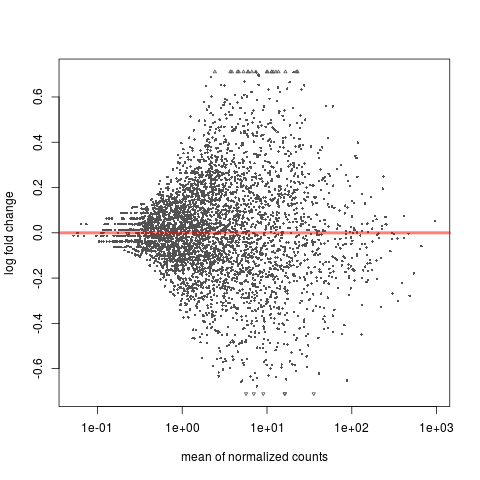

In [9]:
%%R
plotMA(l2f.1_3r)

In [ ]:
## Differential abundance in rhizosphere

In [10]:
%%R
dds = phyloseq_to_deseq2(physeq.plant, ~Rep + Genotype + TimePoint)
d_dds = DESeq(dds, parallel = TRUE)

In [11]:
%%R
l2f.1_2r = results(d_dds, contrast = c("TimePoint", "T2", "T1"), independentFiltering = TRUE, parallel = TRUE)
l2f.1_3r = results(d_dds, contrast = c("TimePoint", "T3", "T1"), independentFiltering = TRUE, parallel = TRUE)
l2f.2_3r = results(d_dds, contrast = c("TimePoint", "T3", "T2"), independentFiltering = TRUE, parallel = TRUE)

l2f.1_2 = l2f.1_2r %>% 
    as.data.frame() %>%
    mutate(OTU = rownames(l2f.1_2r),
           Comparison = "T1-T2",
           Planted = "Rhizosphere") 
l2f.1_3 = l2f.1_3r %>% 
    as.data.frame() %>%
    mutate(OTU = rownames(l2f.1_3r),
           Comparison = "T1-T3",
           Planted = "Rhizosphere") 
l2f.2_3 = l2f.2_3r %>% 
    as.data.frame() %>%
    mutate(OTU = rownames(l2f.2_3r),
           Comparison = "T2-T3",
           Planted = "Rhizosphere") 
l2f.rhiz = bind_rows(l2f.1_2, l2f.1_3, l2f.2_3)
# l2f.1_2 = NULL
# l2f.1_3 = NULL
# l2f.2_3 = NULL

In [12]:
%%R

# Explore rhizosphere responders after multiple comparison correction across all comps
sig = l2f.rhiz %>% filter(padj < 0.05 )

print(paste("OTUs differentially abundant between timepoints: ", 
            sig$OTU %>% unique %>% length, sep = ""))

sig.1_2 = l2f.rhiz %>% filter(padj < 0.05 & Comparison == "T1-T2")
print(paste("OTUs differentially abundant between 1st and 2nd sampling: ", sig.1_2$OTU %>% unique %>% length, sep = ""))

sig.1_3 = l2f.rhiz %>% filter(padj < 0.05  & Comparison == "T1-T3")
print(paste("OTUs differentially abundant between 1st and 3rd sampling: ", sig.1_3$OTU %>% unique %>% length, sep = ""))

sig.2_3 = l2f.rhiz %>% filter(padj < 0.05 &   Comparison == "T2-T3")
print(paste("OTUs differentially abundant between 2nd and 3rd sampling: ", sig.2_3$OTU %>% unique %>% length, sep = ""))



[1] "OTUs differentially abundant between timepoints: 280"
[1] "OTUs differentially abundant between 1st and 2nd sampling: 79"
[1] "OTUs differentially abundant between 1st and 3rd sampling: 258"
[1] "OTUs differentially abundant between 2nd and 3rd sampling: 74"


In [13]:
%%R
tax = tax_table(physeq.plant) %>% as.data.frame %>% mutate(OTU = rownames(.))
sigtab = left_join(sig, tax, by = "OTU")

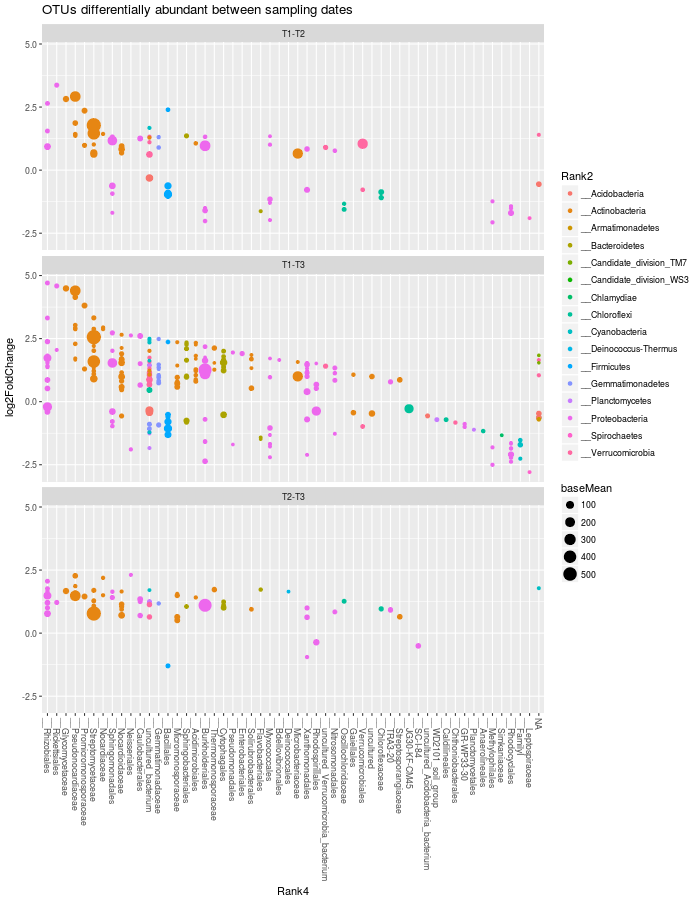

In [14]:
%%R -w 700 -h 900

x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
 # theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs differentially abundant between sampling dates")  +
   theme(legend.position="right") +
    facet_wrap(~Comparison, ncol = 1)
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
 
    p2
   